In [1]:
pip install casadi matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 8.7 MB/s eta 0:00:00


In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# obstacle constraints

def get_rectangle_halfspace(x_center, y_center, width, height):
    # Axis-aligned rectangle
    A = np.array([[ 1, 0],
                  [-1, 0],
                  [0,  1],
                  [0, -1]])
    b = np.array([x_center + width/2,
                 -x_center + width/2,
                  y_center + height/2,
                 -y_center + height/2])
    return A, b

In [4]:
def add_obca_penetration_constraints_opti(opti, X, S, LAMB, MU, A_list, b_list, ego_shape):
    """
    Robust OBCA-style penetration minimization constraints.

    Parameters:
    - opti: casadi.Opti instance
    - X: Opti variable (4 x N+1) state trajectory
    - S: Opti variable (total_m x N+1) slack variables s_k^(m)
    - LAMB: Opti variable (total_m x N+1) λ_k^(m)
    - MU: Opti variable (4*n_obs x N+1) μ_k^(m)
    - A_list: list of (m x 2) numpy arrays (obstacle halfspaces)
    - b_list: list of (m,) numpy arrays (halfspace offsets)
    - ego_shape: array of 4 floats, g vector
    """
    N = X.shape[1]
    n_obs = len(A_list)
    offset = (ego_shape[0] + ego_shape[2]) / 2 - ego_shape[2]  # geometric center offset
    g_obs = ca.DM(ego_shape)
    m_list = [A.shape[0] for A in A_list]
    cum_m = np.cumsum([0] + m_list)

    for k in range(N):
        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB[cum_m[j]:cum_m[j + 1], k]
            mu_jk = MU[4 * j:4 * (j + 1), k]
            s_jk = S[cum_m[j]:cum_m[j + 1], k]

            # (1) Slack-based separation constraint
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep + s_jk >= 0)

            # (2) Dual feasibility constraint: G^T * mu + R^T * A^T * lambda = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            opti.subject_to(G_mu + R.T @ AT_lambda == 0)

            # (3) Norm constraint ||A^T * lambda|| = 1 (relaxed inequality) # giving NaN
            # norm_val = ca.norm_2(AT_lambda)
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            # opti.subject_to(norm_val <= 1)
            opti.subject_to(norm_sq == 1)


In [5]:
# Dynamics
def f_dyn(x, u):
    xdot = x[3] * ca.cos(x[2])
    ydot = x[3] * ca.sin(x[2])
    thetadot = x[3] / L * ca.tan(u[1])
    vdot = u[0]
    return ca.vertcat(xdot, ydot, thetadot, vdot)

In [6]:
nx = 4 #state variale dimension -- x, y, theta, v
nu = 2 # control var dimension -- a, delta

# Vehicle model
L = 2
W = L/2

# Initial and final state
x_init = np.array([0.0, 0.0, 0.0, 0.0])
x_goal = np.array([7.5, -3.25, 0.0, 0.0])

# Time horizon and discretization
N = 60  # number of control intervals
#T = 10.0  # total time
dt = 0.1

# Cost weights
Q = np.diag([40, 40, 40, 20])*20 #np.diag([22, 22, 10, 20]) #Previously *10
# Qf = np.diag([100, 100, 50, 50])
Qf = np.diag([80, 80, 20, 20])*20 #np.diag([40, 40, 10, 20])
R = np.diag([1, 0.1])

print(Q, R, Qf)

kappa = 60000 # slack variable weight

[[800   0   0   0]
 [  0 800   0   0]
 [  0   0 800   0]
 [  0   0   0 400]] [[1.  0. ]
 [0.  0.1]] [[1600    0    0    0]
 [   0 1600    0    0]
 [   0    0  400    0]
 [   0    0    0  400]]


In [7]:
# Define obstacles
# Define obstacles
obstacles = [
    (3, -4, 6, 3),   # (x_center, y_center, width, height)
    (7.5, -4.75, 3, 1.5),
    (12, -4, 6, 3)
]
A_obs1, b_obs1 = get_rectangle_halfspace(*obstacles[0])
A_obs2, b_obs2 = get_rectangle_halfspace(*obstacles[1])
A_list = [A_obs1, A_obs2]
b_list = [b_obs1, b_obs2]
total_m = sum(A.shape[0] for A in A_list)

In [8]:
# Bounds on states and control
v_min, v_max = -1.0, 2.0
a_min, a_max = -1.0, 1.0
delta_min, delta_max = -1, 1

In [9]:
# Solver setup
opts = {
    'ipopt': {
        'print_level': 5,
        'max_iter': 500,
        'tol': 1e-6,
        'acceptable_tol': 1e-4,
        'print_timing_statistics': 'no',
        'warm_start_init_point': 'yes',
        'sb': 'yes'
    },
    'print_time': False
}

In [10]:
# Parameters
N_sim = 3*N                     # Total number of MPC steps
x_curr = x_init.copy()         # Start from initial state
X_hist = [x_curr]              # For storing state trajectory
U_hist = []                    # For storing applied controls

for sim_step in range(N_sim):
    opti = ca.Opti()

    # Decision variables
    X = opti.variable(nx, N+1)
    U = opti.variable(nu, N)
    LAMB = opti.variable(total_m, N+1)
    MU = opti.variable(nx * len(A_list), N+1)
    s = opti.variable(total_m, N+1)

    # Cost
    cost = 0
    for k in range(N):
        cost += ca.mtimes((X[:,k] - x_goal).T, Q @ (X[:,k] - x_goal))
        cost += ca.mtimes(U[:,k].T,R @ U[:,k])
        cost += kappa * ca.sum1(s[:,k]) # slack variable cost
    # soft terminal constraint imposition through terminal cost
    cost += ca.mtimes((X[:,N] - x_goal).T, Qf @ (X[:,N] - x_goal))
    opti.minimize(cost)

    # Bounds
    for k in range(N+1):
        opti.subject_to(X[3,k] >= v_min)
        opti.subject_to(X[3,k] <= v_max)
    for k in range(N):
        opti.subject_to(U[0,k] >= a_min)
        opti.subject_to(U[0,k] <= a_max)
        opti.subject_to(U[1,k] >= delta_min)
        opti.subject_to(U[1,k] <= delta_max)

    # Dynamics
    for k in range(N):
        x_next = X[:,k] + dt * f_dyn(X[:,k], U[:,k])
        opti.subject_to(X[:,k+1] == x_next)

    # Initial condition
    opti.subject_to(X[:,0] == x_curr)
    # (Optional) hard terminal constraint imposition in last iter (may make the optimization infeasible)
    # if sim_step == N_sim - 1:
        # opti.subject_to(X[:, -1] == x_goal)

    # OBCA constraints
    add_obca_penetration_constraints_opti(opti, X, s, LAMB, MU, A_list, b_list,
                                           ego_shape=[L/2,W/2,L/2,W/2])
    opti.subject_to(ca.vec(LAMB) >= 0)
    opti.subject_to(ca.vec(MU) >= 0)
    opti.subject_to(ca.vec(s) >= 0)


    # Initial guess
    if sim_step > 0:
        x_guess = np.hstack([X_prev[:,1:], X_prev[:,-1:]])
        u_guess = np.hstack([U_prev[:,1:], U_prev[:,-1:]])
        s_guess = np.hstack([S_prev[:,1:], S_prev[:,-1:]])
        lamb_guess = np.hstack([LAMB_prev[:,1:], LAMB_prev[:,-1:]])
        mu_guess = np.hstack([MU_prev[:,1:], MU_prev[:,-1:]])
    else:
        x_guess = np.tile(x_curr.reshape(-1, 1), (1, N+1))
        u_guess = np.zeros((2, N))
        # s_guess = 1e-1 * np.ones((total_m, N+1))
        # lamb_guess = 1e-1 * np.ones((total_m, N+1))
        # mu_guess = 1e-1 * np.ones((nx * len(A_list), N+1))

    opti.set_initial(X, x_guess)
    opti.set_initial(U, u_guess)
    # opti.set_initial(s, s_guess)
    # opti.set_initial(LAMB, lamb_guess)
    # opti.set_initial(MU, mu_guess)


    # Solver
    opti.solver('ipopt', opts)


    try:
        sol = opti.solve()
        u_apply = sol.value(U)[:, 0]                    # First control
        x_next = x_curr + dt * f_dyn(x_curr, u_apply)   # Forward simulate

        # Extract predicted trajectories for warm start
        X_prev = sol.value(X)
        U_prev = sol.value(U)
        S_prev = sol.value(s)
        LAMB_prev = sol.value(LAMB)
        MU_prev = sol.value(MU)


        # Store
        U_hist.append(u_apply)
        X_hist.append(x_next.full().flatten())

        # Update state
        x_curr = x_next.full().flatten()

    except RuntimeError as e:
        print(f"MPC failed at step {sim_step}: {e}")
        print("x_curr =", x_curr)
        # Debug
        # opti.debug.show_infeasibilities()
        # raise
        try:
            print("Last known guess for control:", opti.debug.value(U)[:, 0])
        except:
            print("Failed to retrieve debug values.")
        break


Streaming output truncated to the last 5000 lines.
  24  1.6284235e+07 8.76e-01 5.57e+04  -1.0 2.39e+00   3.4 1.12e-01 9.87e-03h  1
  25  1.6351034e+07 8.70e-01 7.82e+04  -1.0 2.27e+00   3.8 1.86e-01 6.78e-03h  1
  26  1.6486622e+07 8.57e-01 1.49e+05  -1.0 2.19e+00   4.3 1.96e-01 1.40e-02h  1
  27  1.6707409e+07 8.36e-01 3.43e+05  -1.0 2.06e+00   4.7 2.11e-01 2.41e-02h  1
  28  1.6744743e+07 8.32e-01 8.81e+05  -1.0 1.87e+00   5.1 2.13e-01 4.48e-03h  1
  29  1.7287933e+07 7.76e-01 8.37e+05  -1.0 1.95e+00   4.6 1.49e-01 6.26e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7352350e+07 7.72e-01 1.05e+06  -1.0 2.04e+00   5.1 1.13e-01 5.39e-03h  1
  31  1.7590363e+07 7.60e-01 3.94e+06  -1.0 2.20e+00   5.5 2.46e-01 1.48e-02h  1
  32  1.9833757e+07 6.51e-01 3.40e+06  -1.0 7.34e+00   5.0 2.97e-02 1.30e-01h  1
  33  1.9849184e+07 6.50e-01 3.07e+06  -1.0 1.55e+00   4.5 1.03e-01 1.25e-03h  1
  34  2.0754951e+07 6.02e-01 2.74e+06  -1.0 1.54e+00   5.0

(4, 181)
(2, 180)
(181,)


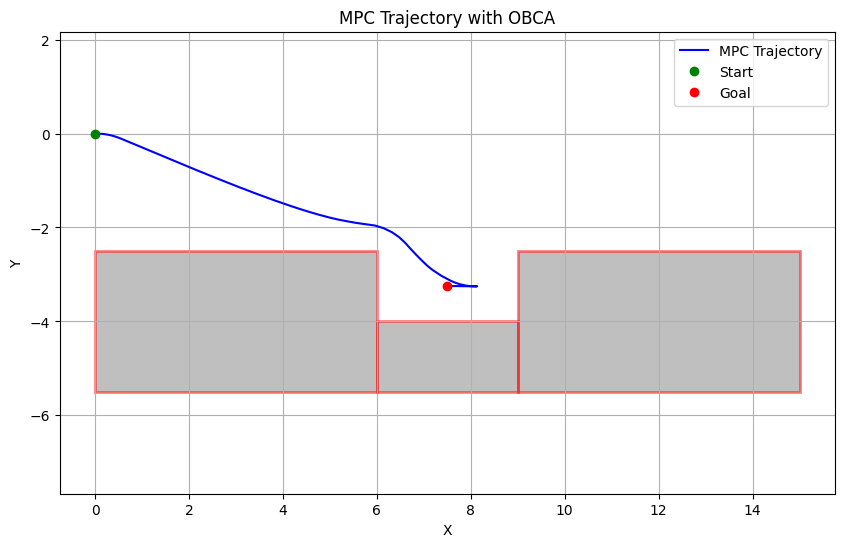

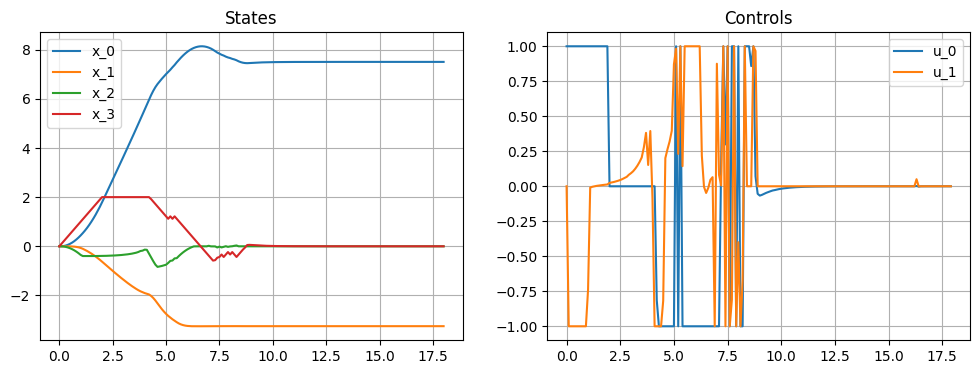

In [11]:
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation

X_mpc = np.array(X_hist).T
print(X_mpc.shape)
U_mpc = np.array(U_hist).T
print(U_mpc.shape)
t_eval_mpc = np.linspace(0, N_sim*dt, N_sim+1)
print(t_eval_mpc.shape)
# Trajectory plot
plt.figure(figsize=(10, 6))
plt.plot(X_mpc[0, :], X_mpc[1, :], 'b-', label='MPC Trajectory')
plt.plot(x_init[0], x_init[1], 'go', label='Start')
plt.plot(x_goal[0], x_goal[1], 'ro', label='Goal')
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    plt.gca().add_patch(rect)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.title("MPC Trajectory with OBCA")
plt.legend()
plt.show()

# State + Control time series
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(nx):
    plt.plot(t_eval_mpc, X_mpc[i, :], label=f"x_{i}")
plt.legend(); plt.title("States")
plt.grid()

plt.subplot(1, 2, 2)
for i in range(nu):
    plt.plot(t_eval_mpc[:-1], U_mpc[i, :], label=f"u_{i}")
plt.legend(); plt.title("Controls")
plt.grid()
plt.show()


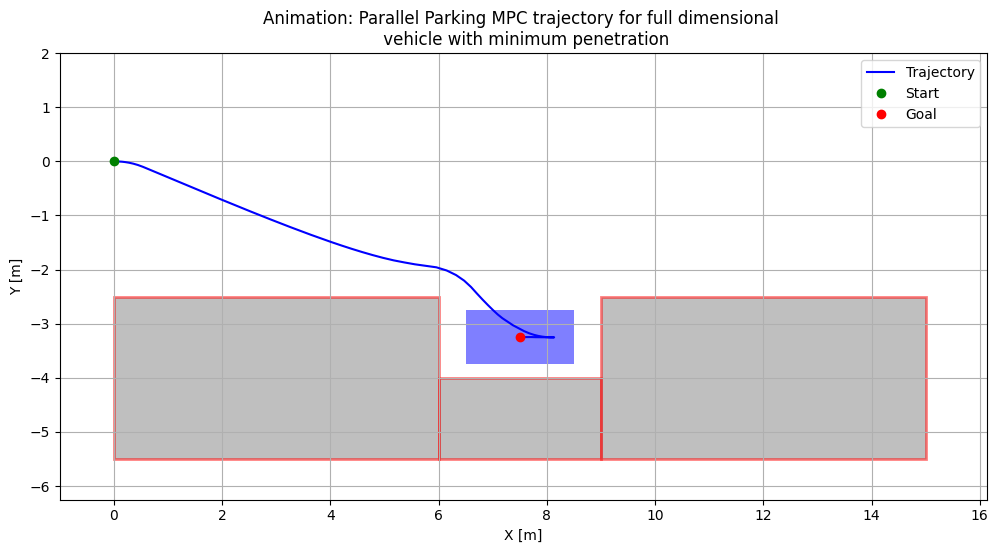

In [13]:
## Animation

# Car dimensions
car_length = L
car_width = W

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
ax.set_xlim(np.min(X_mpc[0, :]) - 1, np.max(X_mpc[0, :]) + 8)
ax.set_ylim(np.min(X_mpc[1, :]) - 3, np.max(X_mpc[1, :]) + 2)
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Animation: Parallel Parking MPC trajectory for full dimensional \n vehicle with minimum penetration")

# Initialize plot elements
trajectory_line, = ax.plot([], [], 'b-', label='Trajectory')
start_point = ax.plot(x_init[0], x_init[1], 'go', label='Start')[0]
goal_point = ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')[0]

# Car rectangle initialized at (0, 0) relative to its own frame
car_patch = Rectangle((-car_length / 2, -car_width / 2), car_length, car_width,
                      facecolor='blue', alpha=0.5)
ax.add_patch(car_patch)

# Plot obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)
ax.legend()

# Animation update function
def update(frame):
    x, y, theta = X_mpc[0, frame], X_mpc[1, frame], X_mpc[2, frame]

    # Update trajectory line
    trajectory_line.set_data(X_mpc[0, :frame+1], X_mpc[1, :frame+1])

    # Rotate and translate car patch
    transform = Affine2D().rotate(theta).translate(x, y) + ax.transData
    car_patch.set_transform(transform)

    return trajectory_line, car_patch

# Animate
ani = animation.FuncAnimation(fig, update, frames=X_mpc.shape[1], interval=100, blit=True)

# Save to file
ani.save("mpc_MinPen_FullDim_ParallelPark_01June2025.gif", writer='pillow', fps=10)

plt.show()


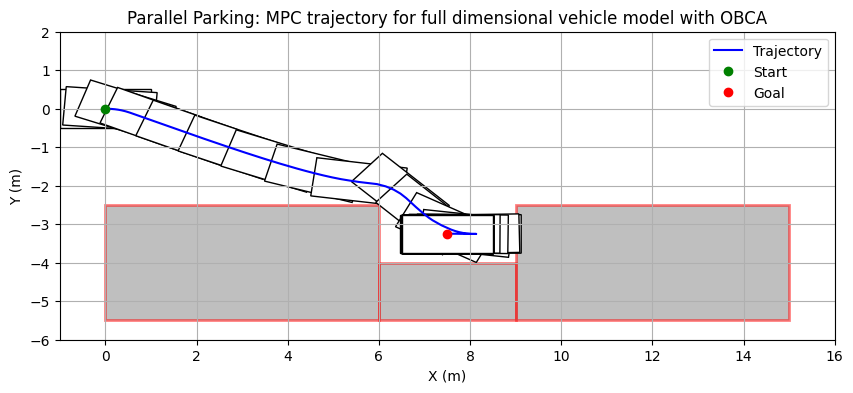

In [15]:
# Trajectory plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(X_mpc[0, :], X_mpc[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='grey', alpha = 0.5)
    ax.add_patch(rect)

for i in range(0, N_sim, 5):
    veh_pose = Rectangle((X_mpc[0, i] - car_length/2, X_mpc[1, i] - car_width/2), car_length, car_width,
                      facecolor='white', edgecolor='black')

    trans = Affine2D().rotate_deg_around(X_mpc[0, i], X_mpc[1, i], np.rad2deg(X_mpc[2, i])) + ax.transData
    veh_pose.set_transform(trans)

    ax.add_patch(veh_pose)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_ylim(-6, 2)
ax.set_xlim(-1, 16)
#ax.set_xticklabels(np.linspace(-1, 18, 20))
ax.grid(True)
ax.set_title("Parallel Parking: MPC trajectory for full dimensional vehicle model with OBCA")
ax.legend()
fig.savefig("June6mpc_trajectory_parallelPark_FullDim_MinPen.png", dpi=300, bbox_inches='tight')
plt.show()
fig.clf()
plt.close(fig)